In [1]:
# ==============================================================================
# PREDICCIÓN DE DEMANDA DE TICKETS
# ==============================================================================

# 1. LIBRERÍAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
# from lightgbm import LGBMRegressor # Opcional si está instalado
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from prophet import Prophet # Opcional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ==============================================================================
# 2. CARGA Y PREPROCESAMIENTO DE TUS DATOS REALES
# ==============================================================================
print("Cargando y procesando datos...")

# Cargar tu archivo CSV
df = pd.read_csv('tickets_fechas_reordenadas_2022_2025.csv')

# Convertir columna fecha a datetime y limpiar
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
df = df.dropna(subset=['fecha'])

# Extraer solo la fecha (día) y contar tickets por día
df_diario = df.groupby(df['fecha'].dt.date).size().reset_index(name='tickets')
df_diario['fecha'] = pd.to_datetime(df_diario['fecha'])
df_diario.set_index('fecha', inplace=True)

# Rellenar días faltantes con 0 (importante para series temporales)
df_diario = df_diario.asfreq('D').fillna(0)

print(f"Serie temporal creada: {len(df_diario)} días")

# División Train/Test (Últimos 30 días para validación)
test_days = 30
train = df_diario.iloc[:-test_days]
test = df_diario.iloc[-test_days:]
y_test = test['tickets']

Cargando y procesando datos...
Serie temporal creada: 1457 días


In [3]:
# ==============================================================================
# 3. ENTRENAMIENTO DE MODELOS
# ==============================================================================
preds = {} # Diccionario para guardar predicciones

# --- A. MODELOS ESTADÍSTICOS ---
print("Entrenando ARIMA y SARIMAX...")
try:
    model_arima = ARIMA(train['tickets'], order=(5,1,0))
    model_fit = model_arima.fit()
    preds['ARIMA'] = model_fit.forecast(steps=test_days)
except: preds['ARIMA'] = np.zeros(test_days)

try:
    model_sarima = SARIMAX(train['tickets'], order=(1,1,1), seasonal_order=(1,1,1,7))
    sarima_fit = model_sarima.fit(disp=False)
    preds['SARIMAX'] = sarima_fit.forecast(steps=test_days)
except: preds['SARIMAX'] = np.zeros(test_days)

# --- C. MACHINE LEARNING (RF, SVR) ---
print("Entrenando Machine Learning...")
def create_features(data, lags=7):
    X, y = [], []
    for i in range(lags, len(data)):
        X.append(data[i-lags:i])
        y.append(data[i])
    return np.array(X), np.array(y)

data_values = df_diario['tickets'].values
X, y = create_features(data_values)
X_train_ml = X[:-test_days]
y_train_ml = y[:-test_days]
X_test_ml = X[-test_days:]

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_ml, y_train_ml)
preds['RandomForest'] = rf.predict(X_test_ml)

svr = SVR(kernel='rbf')
svr.fit(X_train_ml, y_train_ml)
preds['SVR'] = svr.predict(X_test_ml)

# --- D. DEEP LEARNING (LSTM, GRU) ---
print("Entrenando Deep Learning...")
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_diario['tickets'].values.reshape(-1,1))

def create_sequences(data, seq_length=7):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LEN = 7
X_dl, y_dl = create_sequences(scaled_data, SEQ_LEN)
X_train_dl = X_dl[:-test_days]
y_train_dl = y_dl[:-test_days]
X_test_dl = X_dl[-test_days:]

# LSTM (Aumentamos épocas para mejor resultado real)
model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(SEQ_LEN, 1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_dl, y_train_dl, epochs=50, verbose=0)
preds['LSTM'] = scaler.inverse_transform(model_lstm.predict(X_test_dl, verbose=0)).flatten()

# GRU
model_gru = Sequential([GRU(50, activation='relu', input_shape=(SEQ_LEN, 1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_train_dl, y_train_dl, epochs=50, verbose=0)
preds['GRU'] = scaler.inverse_transform(model_gru.predict(X_test_dl, verbose=0)).flatten()

Entrenando ARIMA y SARIMAX...
Entrenando Machine Learning...
Entrenando Deep Learning...


In [4]:
# ==============================================================================
# 4. EVALUACIÓN Y RESULTADOS (TABLA + GRÁFICAS)
# ==============================================================================
print("\nGenerando resultados finales...")

metrics = []
for name, y_pred in preds.items():
    current_y_test = y_test[:len(y_pred)]
    y_pred = y_pred[:len(current_y_test)]
    
    r2 = r2_score(current_y_test, y_pred)
    mse = mean_squared_error(current_y_test, y_pred)
    mae = mean_absolute_error(current_y_test, y_pred)
    metrics.append({'Modelo': name, 'R2': r2, 'MSE': mse, 'MAE': mae})

metrics_df = pd.DataFrame(metrics).sort_values('R2', ascending=False)
print("\n--- TABLA COMPARATIVA DE MODELOS ---")
display(metrics_df)


Generando resultados finales...

--- TABLA COMPARATIVA DE MODELOS ---


,Modelo,R2,MSE,MAE
1,SARIMAX,0.736030,1.353873,0.818639
4,LSTM,0.719056,1.440932,0.919955
5,GRU,0.708343,1.495877,0.859171
3,SVR,0.669210,1.696584,0.901539
2,RandomForest,0.588899,2.108490,1.008529
0,ARIMA,-0.317816,6.758932,2.380494


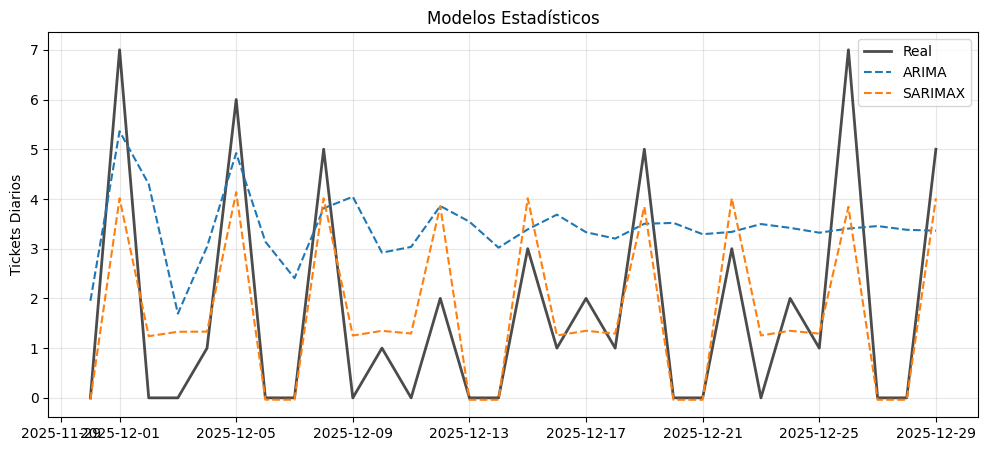

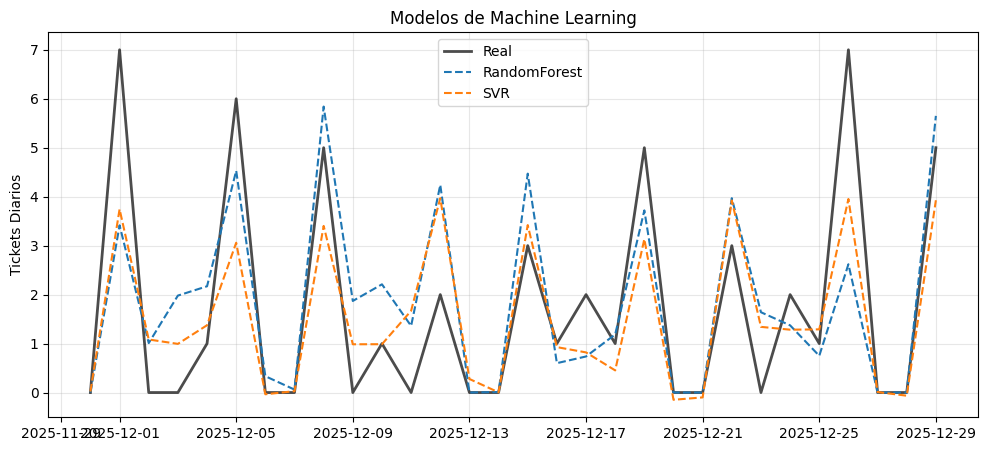

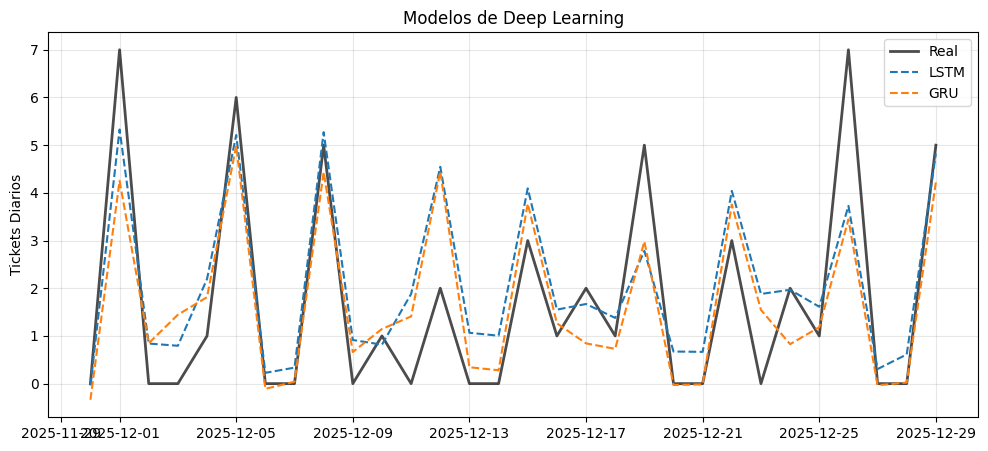

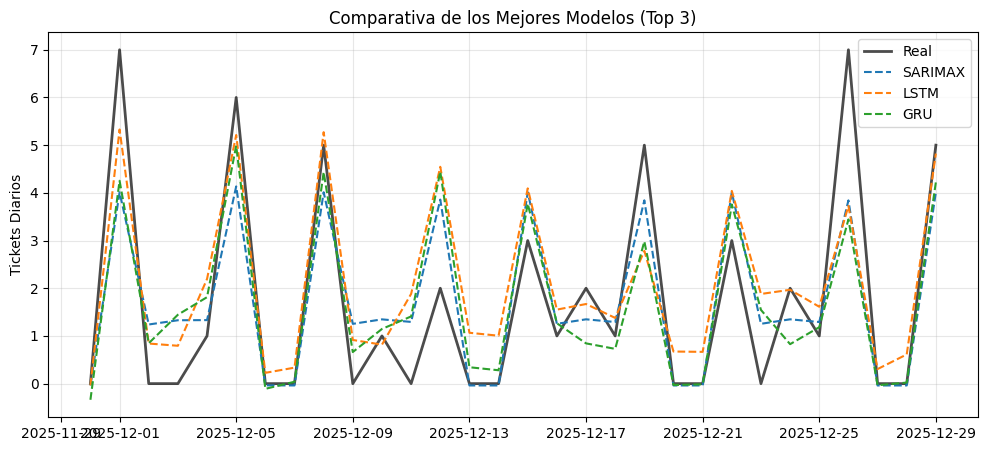

¡Proceso completado!


In [5]:
# Gráficas Separadas
def plot_group(model_names, title, filename):
    plt.figure(figsize=(12, 5))
    plt.plot(test.index, test['tickets'], label='Real', color='black', linewidth=2, alpha=0.7)
    for name in model_names:
        if name in preds:
            plt.plot(test.index, preds[name], label=name, linestyle='--')
    plt.title(title)
    plt.ylabel('Tickets Diarios')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(filename, dpi=300)
    plt.show()

plot_group(['ARIMA', 'SARIMAX'], 'Modelos Estadísticos', 'fig1_tradicionales.png')
plot_group(['RandomForest', 'SVR'], 'Modelos de Machine Learning', 'fig2_ml.png')
plot_group(['LSTM', 'GRU'], 'Modelos de Deep Learning', 'fig3_dl.png')

# 4. Los Mejores (Top 3 por R2)
top_3_models = metrics_df.head(3)['Modelo'].tolist()
plot_group(top_3_models, 'Comparativa de los Mejores Modelos (Top 3)', 'fig4_final.png')

print("¡Proceso completado!")